# 10_fold Random distribution of data set- Accelerometer

In [175]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [176]:
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [177]:
from numba import njit

In [178]:
sample_rate = 50  # number of observation per second based on dataset documentation(150 samples in 3 second)

sliding_size = int((1/3) * sample_rate)  # number of skipped datapoints to start next window
print(sliding_size)

16


# Feature sets

In [179]:
@njit()
def mean_crossing_rate(col):
    # col = np.array(values)
    normalized = col - col.mean()  # to make elements of array possitive or negetive
    return ((normalized[:-1] * col[1:]) < 0).sum()  # Zero-Crossing_rate

@njit()
def iqr(window):  # inter-quartile range
    Q1 = np.median(window[:len(window)//2])  # First quartile (Q1) 
    Q3 = np.median(window[len(window)//2:])  # Third quartile (Q3) 
    IQR = Q3 - Q1 # Interquartile range (IQR) 
    return(IQR) 
@njit()
def calc_sma_for_window(data):
    return np.sum(data) / len(data)  
@njit()
def get_min(x):
    m = np.min(x)
    return m
@njit()
def get_max(x):
    m = np.max(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_var(x):
    m = np.var(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_sum(x):
    m = x.sum()
    return m 
@njit()
def get_median(x):
    m = np.median(x)
    return m 
@njit()
def get_std(x):
    m = np.median(x)
    return m 



In [180]:
def Energy(frame):
    return sum( [ abs(x)**2 for x in frame ] ) / len(frame)

In [181]:
def Features(window):# mean, std,max,min and zero-crossing-rate
    win = np.array(window[:-1])
    features = []
    
    features.append(get_mean(win))
    features.append(get_median(win))
    features.append(get_var(win))
    features.append(get_std(win))
    features.append(get_min(win))
    features.append(get_max(win))
    features.append(get_sum(win))
    mean_crossing = [mean_crossing_rate(window.iloc[:, i].values) for i in range(window.shape[1] - 1)]
    features.append(np.array(mean_crossing))
    IQR = iqr(win)
    features.append(np.array(IQR))
    energy_measure = Energy(win)
    features.append(np.array(energy_measure))
 

    features = np.hstack(features).tolist()

    label = window.iloc[:, -1].mode()[0]  ## select the most frequent label as the label of the window
    features.append(label)
    return features

In [182]:
def windowing_dataset(dataset, datapoints_per_window, feature_extraction_function, subject_id, overlap):
    windowed_dataset = []
    win_count = 0
    if overlap:
        step_size = sliding_size  # for Overlapping technique
    else:
        step_size = datapoints_per_window  # for Non-overlapping technique

    for index in range(0, dataset.shape[0], step_size):
        start = index
        end = start + datapoints_per_window
        # to assure all of windows are equal in size
        if (end <= dataset.shape[0]):
            window = dataset.iloc[start:end, :].reset_index(drop=True)
            win_count = win_count + 1
            features = feature_extraction_function(window)

            windowed_dataset.append(features)

    final = pd.DataFrame(windowed_dataset)
    final.insert(0, 'group', subject_id)  # to use in Subject CV
    return final

In [183]:
def Preprocessing(dataset_path, overlapping):
    feature_extraction_function = Features
    win_size = 3
    #for win_size in win_sizes:
    print("Start for win size {}".format(win_size))
    datapoints_per_window = int(win_size * sample_rate)

    #for feature_function in features_functions:

    print(feature_extraction_function.__name__)

    windowed_dataset = []

    for subject in range(1,18):
        file_path = dataset_path + '/subject{}_ideal.csv'.format(subject)
        acc_cols = []
        for i in range(2, 117, 13):# indices of accelarations
            indices = list(range(i, i + 3))
            acc_cols.extend(indices)

        acc_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=acc_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_extraction_function, subject,
                                                   overlap=overlapping)

        windowed_dataset.append(transformed_db)

    final_dataset = pd.DataFrame()
    print("Features")
    final_dataset = pd.concat(windowed_dataset, ignore_index=True)
    return final_dataset
   

In [184]:
def subject_cross_validation(X, Y, groups, classifier):
    f1 = []
    logo = LeaveOneGroupOut()
    i = 0
    for train_index, test_index in logo.split(X, Y, groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        i += 1
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)
        f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
        
        print(classifier,' Model-',i ,' -',' f1 score: ', f)
       
        f1.append(f)
    return np.mean(f1)

In [185]:
# cv_strategy can be iid or sbj for k-fold cv and subject cv respectively

def apply_classifiers(dataset, models, cv_strategy):
    results = dict()
    win_size = float(3)
    print('window_size = ', win_size,' sec')

    dataset = dataset
    groups = dataset['group']
    X = dataset.iloc[:, 1:-1].values
    
    pca = PCA(n_components=30, random_state = 42)
    pca.fit(X)
    X = pca.transform(X)
    
    Y = dataset.iloc[:, -1].values


    for model_name, model in models.items():
        f1 = 0

        if cv_strategy == 'sbj':

            f1 = subject_cross_validation(X, Y, groups, model)
            
        else:
            f1 = cross_val_score(estimator=model, X=X, y=Y,
                                    cv=KFold(n_splits=10, shuffle=True, random_state=1), scoring='f1_micro',
                                    n_jobs=-1).mean()

        if win_size in results:
            results[win_size].append(f1)
        else:
            results[win_size] = [f1]

        

        results = collections.OrderedDict(sorted(results.items()))

        final = []
        col = list(models.keys())
        col.insert(0, "window-size")
        final.append(col)
        for k, v in results.items():
            tmp = []
            tmp.append([k])
            tmp.append(v)
            flattened = [val for sublist in tmp for val in sublist]
            final.append(flattened)
    final = pd.DataFrame(final)   
    return final

In [186]:
models = {'DT': DecisionTreeClassifier(criterion='entropy'), 'NB': GaussianNB(),
          'NCC': NearestCentroid(), "KNN": KNeighborsClassifier(n_neighbors=3),
          'RF': RandomForestClassifier(n_estimators=40,criterion = 'entropy', random_state=42, n_jobs=-1)}

In [187]:
%%time
dataset_csv_path = r"./data_csv"

overlapping = 1

df = Preprocessing(dataset_path=dataset_csv_path, overlapping=bool(int(overlapping)))

df.head(10)

Start for win size 3
Features


Features
CPU times: user 14min 44s, sys: 1.32 s, total: 14min 45s
Wall time: 14min 46s


,group,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,1,-2.078883,-0.718835,26.648090,-0.718835,-9.7956,5.1017,-8673.099056,70.0,77.0,...,0.327176,4.161465,84.846366,4.315635,7.096344,94.012496,2.321786,0.003073,0.0,0
1,1,-2.078166,-0.721225,26.653173,-0.721225,-9.7905,5.1017,-8670.108935,70.0,78.0,...,0.328075,4.176093,84.871301,4.315726,7.069882,93.999126,2.320888,0.002765,0.0,0
2,1,-2.078076,-0.721225,26.650759,-0.721225,-9.7905,5.1017,-8669.733107,69.0,78.0,...,0.328086,4.181952,84.880656,4.311784,7.052676,94.005845,2.323826,0.002801,0.0,0
3,1,-2.077607,-0.721225,26.650066,-0.721225,-9.7905,5.1017,-8667.775603,66.0,78.0,...,0.329145,4.188120,84.890716,4.314522,7.034366,94.003096,2.321418,0.002727,0.0,0
4,1,-2.077610,-0.721225,26.649243,-0.721225,-9.7765,5.1017,-8667.790040,68.0,75.0,...,0.331132,4.185914,84.912723,4.315504,7.023657,94.014871,2.324281,0.002617,0.0,0
5,1,-2.077484,-0.753915,26.650443,-0.753915,-9.7765,5.1017,-8667.262855,71.0,74.0,...,0.331374,4.185002,84.925843,4.311291,7.014771,94.030213,2.320096,0.002549,0.0,0
6,1,-2.076904,-0.765170,26.651252,-0.765170,-9.7765,5.1017,-8664.843025,70.0,72.0,...,0.329636,4.193873,84.955471,4.301752,6.993520,94.036517,2.311531,0.002421,0.0,0
7,1,-2.076530,-0.765170,26.653948,-0.765170,-9.7765,5.1017,-8663.285231,74.0,75.0,...,0.329502,4.204081,84.970361,4.298889,6.980400,94.054315,2.314172,0.002324,0.0,0
8,1,-2.076010,-0.770395,26.653875,-0.770395,-9.7765,5.1017,-8661.113169,77.0,73.0,...,0.329932,4.207928,84.981540,4.291551,6.968054,94.070478,2.308113,0.002220,0.0,0
9,1,-2.075788,-0.770395,26.656746,-0.770395,-9.7849,5.0611,-8660.186328,75.0,73.0,...,0.327908,4.205660,84.996578,4.282679,6.962403,94.069767,2.304537,0.002286,0.0,0


### K-fold Feature extraction and Classification for ACC sensor

In [188]:
%%time
dataset = df

df_iid = apply_classifiers(dataset=dataset, models=models, cv_strategy='iid')
df_iid

window_size =  3.0  sec
CPU times: user 11.9 s, sys: 6.05 s, total: 17.9 s
Wall time: 20min 20s


,0,1,2,3,4,5
0,window-size,DT,NB,NCC,KNN,RF
1,3.0,0.979291,0.932522,0.098296,0.976417,0.99125


### Subject Wise Feature extraction and Classification for ACC sensor

In [189]:
%%time
dataset = df

df_sbj = apply_classifiers(dataset=dataset, models=models, cv_strategy='sbj')
df_sbj

window_size =  3.0  sec
DecisionTreeClassifier(criterion='entropy')  Model- 1  -  f1 score:  0.9232626777569092
DecisionTreeClassifier(criterion='entropy')  Model- 2  -  f1 score:  0.9340669014084507
DecisionTreeClassifier(criterion='entropy')  Model- 3  -  f1 score:  0.8337037037037036
DecisionTreeClassifier(criterion='entropy')  Model- 4  -  f1 score:  0.8848065701318347
DecisionTreeClassifier(criterion='entropy')  Model- 5  -  f1 score:  0.9258671666546477
DecisionTreeClassifier(criterion='entropy')  Model- 6  -  f1 score:  0.9085705199554778
DecisionTreeClassifier(criterion='entropy')  Model- 7  -  f1 score:  0.9626815265113138
DecisionTreeClassifier(criterion='entropy')  Model- 8  -  f1 score:  0.9115215290454204
DecisionTreeClassifier(criterion='entropy')  Model- 9  -  f1 score:  0.9456174522789248
DecisionTreeClassifier(criterion='entropy')  Model- 10  -  f1 score:  0.9301896935719223
DecisionTreeClassifier(criterion='entropy')  Model- 11  -  f1 score:  0.8664148351648352
Decisi

,0,1,2,3,4,5
0,window-size,DT,NB,NCC,KNN,RF
1,3.0,0.905698,0.916493,0.098117,0.917662,0.935295


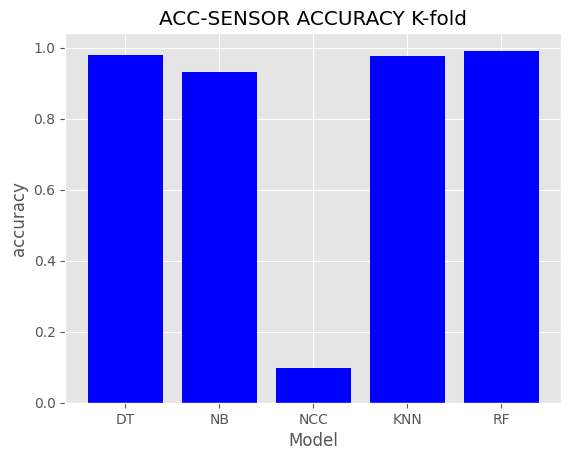

In [202]:
x = ['DT', 'NB', 'NCC', 'KNN','RF']
accuracy = df_iid.iloc[1,1:].values

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracy, color='blue')
plt.xlabel("Model")
plt.ylabel("accuracy")
plt.title("ACC-SENSOR ACCURACY K-fold")

plt.xticks(x_pos, x)

plt.show()

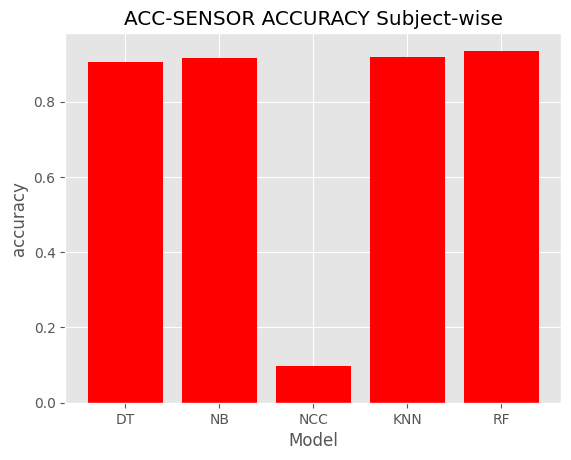

In [203]:
x = ['DT', 'NB', 'NCC', 'KNN','RF']
accuracy = df_sbj.iloc[1,1:].values

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracy, color='red')
plt.xlabel("Model")
plt.ylabel("accuracy")
plt.title("ACC-SENSOR ACCURACY Subject-wise")

plt.xticks(x_pos, x)

plt.show()